<a href="https://colab.research.google.com/github/AlexBorealis/netology_nn/blob/master/kozlov_hw_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [ ]:
import keras
from keras.datasets import cifar10
from keras.callbacks import EarlyStopping, TensorBoard, BackupAndRestore, ReduceLROnPlateau, History
from keras.initializers import HeNormal
from keras.losses import categorical_crossentropy
from keras.metrics import Accuracy, Precision, Recall
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

In [ ]:
%reset -f

In [ ]:
!nvidia-smi

Sun Nov 24 06:46:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 10**4, random_state= 42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)
(10000, 32, 32, 3) (10000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

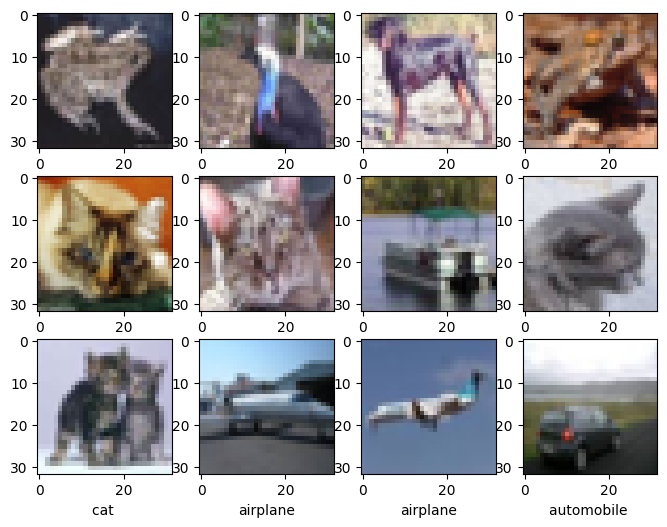

In [ ]:
plt.figure(figsize= [8, 6])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

array([[[ 91,  94,  91],
        [ 95, 113,  88],
        [ 92, 121,  91],
        ...,
        [150, 153, 150],
        [131, 145, 106],
        [ 89, 118,  38]],

       [[100, 136, 101],
        [ 94, 128, 100],
        [ 70, 103,  71],
        ...,
        [ 77,  79,  78],
        [ 99, 114,  90],
        [ 86, 110,  57]],

       [[104, 144,  99],
        [ 85, 122,  85],
        [ 58,  84,  51],
        ...,
        [ 62,  74,  69],
        [ 56,  70,  56],
        [ 67,  85,  57]],

       ...,

       [[118, 107, 103],
        [148, 139, 142],
        [133, 120, 117],
        ...,
        [ 82,  74,  91],
        [124, 109, 119],
        [107,  90,  94]],

       [[143, 122, 125],
        [150, 134, 140],
        [181, 158, 152],
        ...,
        [ 74,  70,  86],
        [110, 102, 106],
        [ 97,  90,  88]],

       [[121, 111, 109],
        [135, 126, 127],
        [155, 138, 136],
        ...,
        [ 65,  57,  74],
        [130, 118, 121],
        [147, 136, 134]]], dtype=uint8)
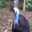

In [ ]:
X_train[1]

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [ ]:
X_train[1]

array([[[0.35686275, 0.36862745, 0.35686275],
        [0.37254902, 0.44313725, 0.34509804],
        [0.36078431, 0.4745098 , 0.35686275],
        ...,
        [0.58823529, 0.6       , 0.58823529],
        [0.51372549, 0.56862745, 0.41568627],
        [0.34901961, 0.4627451 , 0.14901961]],

       [[0.39215686, 0.53333333, 0.39607843],
        [0.36862745, 0.50196078, 0.39215686],
        [0.2745098 , 0.40392157, 0.27843137],
        ...,
        [0.30196078, 0.30980392, 0.30588235],
        [0.38823529, 0.44705882, 0.35294118],
        [0.3372549 , 0.43137255, 0.22352941]],

       [[0.40784314, 0.56470588, 0.38823529],
        [0.33333333, 0.47843137, 0.33333333],
        [0.22745098, 0.32941176, 0.2       ],
        ...,
        [0.24313725, 0.29019608, 0.27058824],
        [0.21960784, 0.2745098 , 0.21960784],
        [0.2627451 , 0.33333333, 0.22352941]],

       ...,

       [[0.4627451 , 0.41960784, 0.40392157],
        [0.58039216, 0.54509804, 0.55686275],
        [0.52156863, 0

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape= X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation= 'relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation= 'relu'),
        tf.keras.layers.Dense(32, activation= 'relu'),
        tf.keras.layers.Dense(10, activation= 'softmax')
])

In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath= './model/model.{epoch:02d}-{val_loss:.2f}.h5.keras'),
    tf.keras.callbacks.TensorBoard(log_dir= './logs'),
    tf.keras.callbacks.EarlyStopping(patience= 5)
]

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │       1,048,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,050,122 (4.01 MB)

 Trainable params: 1,050,122 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## TODO
model.compile(optimizer= 'sgd',
              loss= categorical_crossentropy,
              metrics= ['accuracy', 'precision', 'recall'])
model.fit(
    X_train, y_train, batch_size= 16, epochs= 32,
    callbacks= callbacks, validation_split= .25,
    validation_data= [X_val, y_val]
)

Epoch 1/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.2243 - loss: 2.0843 - precision: 0.4303 - recall: 0.0095 - val_accuracy: 0.3444 - val_loss: 1.7876 - val_precision: 0.5730 - val_recall: 0.0785
Epoch 2/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.3758 - loss: 1.7385 - precision: 0.6260 - recall: 0.0897 - val_accuracy: 0.4024 - val_loss: 1.6678 - val_precision: 0.6264 - val_recall: 0.1658
Epoch 3/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.4250 - loss: 1.6057 - precision: 0.6660 - recall: 0.1682 - val_accuracy: 0.4194 - val_loss: 1.6091 - val_precision: 0.6399 - val_recall: 0.1955
Epoch 4/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.4593 - loss: 1.5255 - precision: 0.6802 - recall: 0.2173 - val_accuracy: 0.4651 - val_loss: 1.5239 - val_precision: 0.6575 - val_recall: 0.2450
Epoch 5/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.4821 - loss: 1.4493 - precision: 0.6928 - recall: 0.2546 - val_accuracy: 0

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x,axis= 1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 Test_acc = 0.5129
 Not bad!


In [ ]:
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       0.55      0.63      0.59      1000
           1       0.68      0.53      0.60      1000
           2       0.41      0.44      0.42      1000
           3       0.34      0.37      0.35      1000
           4       0.42      0.51      0.46      1000
           5       0.42      0.42      0.42      1000
           6       0.64      0.47      0.54      1000
           7       0.57      0.56      0.57      1000
           8       0.62      0.59      0.61      1000
           9       0.58      0.62      0.60      1000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.52     10000
weighted avg       0.52      0.51      0.52     10000



## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
## TODO
new_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape= X_train.shape[1:]),
        tf.keras.layers.Conv2D(filters= 10, kernel_size= (3, 3),
                               activation= 'leaky_relu', padding= 'same'),
        tf.keras.layers.MaxPooling2D(pool_size= (2, 2), padding= 'valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation= 'leaky_relu'),
        tf.keras.layers.Dense(10, activation= 'softmax')
])

In [ ]:
new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath= './new_model/new_model.{epoch:02d}-{val_loss:.2f}.h5.keras'),
    tf.keras.callbacks.TensorBoard(log_dir= './new_logs'),
    tf.keras.callbacks.EarlyStopping(patience= 5)
    ]

In [ ]:
## TODO
new_model.compile(optimizer= 'sgd',
                  loss= categorical_crossentropy,
                  metrics= ['accuracy', 'precision', 'recall'])
new_model.fit(X_train, y_train, batch_size= 16, epochs= 32, callbacks= new_callbacks, validation_split= .25, validation_data= [X_val, y_val])

Epoch 1/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.2767 - loss: 1.9995 - precision: 0.5330 - recall: 0.0286 - val_accuracy: 0.4277 - val_loss: 1.6092 - val_precision: 0.6783 - val_recall: 0.1735
Epoch 2/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.4572 - loss: 1.5349 - precision: 0.6900 - recall: 0.1929 - val_accuracy: 0.4929 - val_loss: 1.4444 - val_precision: 0.6927 - val_recall: 0.2462
Epoch 3/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.5172 - loss: 1.3753 - precision: 0.7177 - recall: 0.2911 - val_accuracy: 0.5105 - val_loss: 1.3793 - val_precision: 0.6968 - val_recall: 0.3188
Epoch 4/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.5497 - loss: 1.2812 - precision: 0.7269 - recall: 0.3484 - val_accuracy: 0.5497 - val_loss: 1.2979 - val_precision: 0.7096 - val_recall: 0.3707
Epoch 5/32
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.5781 - loss: 1.2062 - precision: 0.7479 - recall: 0.3947 - val_accuracy: 0

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x, axis= 1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 Test_acc = 0.6098
 Not bad!


In [ ]:
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       0.56      0.79      0.65      1000
           1       0.73      0.73      0.73      1000
           2       0.55      0.40      0.46      1000
           3       0.45      0.41      0.43      1000
           4       0.58      0.49      0.54      1000
           5       0.52      0.50      0.51      1000
           6       0.71      0.64      0.67      1000
           7       0.64      0.71      0.67      1000
           8       0.68      0.78      0.73      1000
           9       0.65      0.65      0.65      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.60     10000
weighted avg       0.61      0.61      0.60     10000



## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers= 'adam', loss= keras.losses.categorical_crossentropy,
                 metrics= [keras.metrics.categorical_accuracy]):
        if not isinstance(models, dict):
            models = {'single_model': models}

        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}

        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name)
                          for model_name, model in models.items()
                          for optimizer_name in optimizers])

        self.models = models
        self.optimizers = optimizers

        for model_name, model, optimizer_name in self:
            optimizer = self.optimizers[optimizer_name]()
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        self.histories = {}

    def fit(self, X, y, validation_data= (), max_epochs= 20, verbose= 0, callbacks= [], batch_size= 32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]

        history_dict = {}

        for model_name, model, optimizer_name in tqdm(self):
            print(f'Training {model_name} with {optimizer_name} optimizer')
            history = model.fit(X, y, validation_data= validation_data, epochs= max_epochs,
                                batch_size= batch_size, callbacks= callbacks + [
                                    keras.callbacks.TensorBoard(log_dir= f'./logs/{model_name}_{optimizer_name}')],
                                verbose= verbose)
            history_dict[(model_name, optimizer_name)] = history

            self.histories[(model_name, optimizer_name)] = history

        return history_dict

    def fit_generator(self, X, y, validation_data= (), max_epochs= 20, verbose= 1, callbacks= [], batch_size= 32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range= 20,
            width_shift_range= .2,
            height_shift_range= .2,
            horizontal_flip= True
        )

        if not isinstance(callbacks, list):
            callbacks = [callbacks]

        for model_name, model, optimizer_name in tqdm(self):
            model.fit(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                      validation_data=validation_data or None, verbose=verbose,
                      callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def plot_learning_curves(self, figsize_= (12, 8)):
        plt.figure(figsize= figsize_)

        for (model_name, optimizer_name), history in self.histories.items():
            plt.plot(history.history['categorical_accuracy'], label= f'{model_name} - {optimizer_name} (train)')
            plt.plot(history.history['val_categorical_accuracy'], label= f'{model_name} - {optimizer_name} (val)', linestyle='--')

        plt.title('Learning Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name in self:
            score = metric(y.argmax(axis= 1), model.predict(X).argmax(axis= 1))
            print(f'Final score of {model_name}_{optimizer_name} is {score}')

In [ ]:
!rm -rf ./logs

In [ ]:
## TODO
def create_model1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape= X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation= 'relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation= 'relu'),
        tf.keras.layers.Dense(32, activation= 'relu'),
        tf.keras.layers.Dense(10, activation= 'softmax')
    ])

def create_model2():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape= X_train.shape[1:]),
        tf.keras.layers.Conv2D(filters= 10, kernel_size= (3, 3),
                 activation= 'leaky_relu', padding= 'same'),
        tf.keras.layers.MaxPooling2D(pool_size= (2, 2), padding= 'valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation= 'leaky_relu'),
        tf.keras.layers.Dense(10, activation= 'softmax')
    ])

models_ = {
    'Model_1': create_model1(),
    'Model_2': create_model2()
}
optimizers_ = {
    'SGD': SGD,
    'Adam': Adam,
    'RMSprop': RMSprop
}

In [ ]:
callbacks_train = [
    tf.keras.callbacks.ReduceLROnPlateau(
        patience= 5,
        min_delta= 0.001,
    ),
    tf.keras.callbacks.BackupAndRestore(
        backup_dir= '/tmp/backup',
        save_freq= 'epoch'
    )
]

In [ ]:
evaluator = Evaluator(models= models_, optimizers= optimizers_)
evaluator.fit(X_train, y_train, validation_data= (X_val, y_val),
              callbacks= callbacks_train, verbose= 1, max_epochs= 32)

  0%|          | 0/6 [00:00<?, ?it/s]

Training Model_1 with SGD optimizer
Epoch 1/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - categorical_accuracy: 0.2072 - loss: 2.1404 - val_categorical_accuracy: 0.3125 - val_loss: 1.9231 - learning_rate: 0.0100
Epoch 2/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - categorical_accuracy: 0.3572 - loss: 1.8209 - val_categorical_accuracy: 0.3913 - val_loss: 1.7051 - learning_rate: 0.0100
Epoch 3/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - categorical_accuracy: 0.4016 - loss: 1.6934 - val_categorical_accuracy: 0.4059 - val_loss: 1.6824 - learning_rate: 0.0100
Epoch 4/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - categorical_accuracy: 0.4281 - loss: 1.6141 - val_categorical_accuracy: 0.4438 - val_loss: 1.5656 - learning_rate: 0.0100
Epoch 5/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.4601 - loss: 1.5285 - val_categorical_accuracy: 0.4522 - val_loss: 1.5517 - learning_rate: 0.0100
Epoch 6/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - categorical_accura

{('Model_1', 'SGD'): <keras.src.callbacks.history.History at 0x7d43e7579990>,
 ('Model_1', 'Adam'): <keras.src.callbacks.history.History at 0x7d4380630c10>,
 ('Model_1',
  'RMSprop'): <keras.src.callbacks.history.History at 0x7d438015e650>,
 ('Model_2', 'SGD'): <keras.src.callbacks.history.History at 0x7d4310711690>,
 ('Model_2', 'Adam'): <keras.src.callbacks.history.History at 0x7d4311e83f70>,
 ('Model_2',
  'RMSprop'): <keras.src.callbacks.history.History at 0x7d4311e82bf0>}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
evaluator.evaluate(X_val, y_val, accuracy_score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final score of Model_1_SGD is 0.5284
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_1_Adam is 0.4935
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_1_RMSprop is 0.4831
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_2_SGD is 0.6199
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_2_Adam is 0.6449
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_2_RMSprop is 0.6524


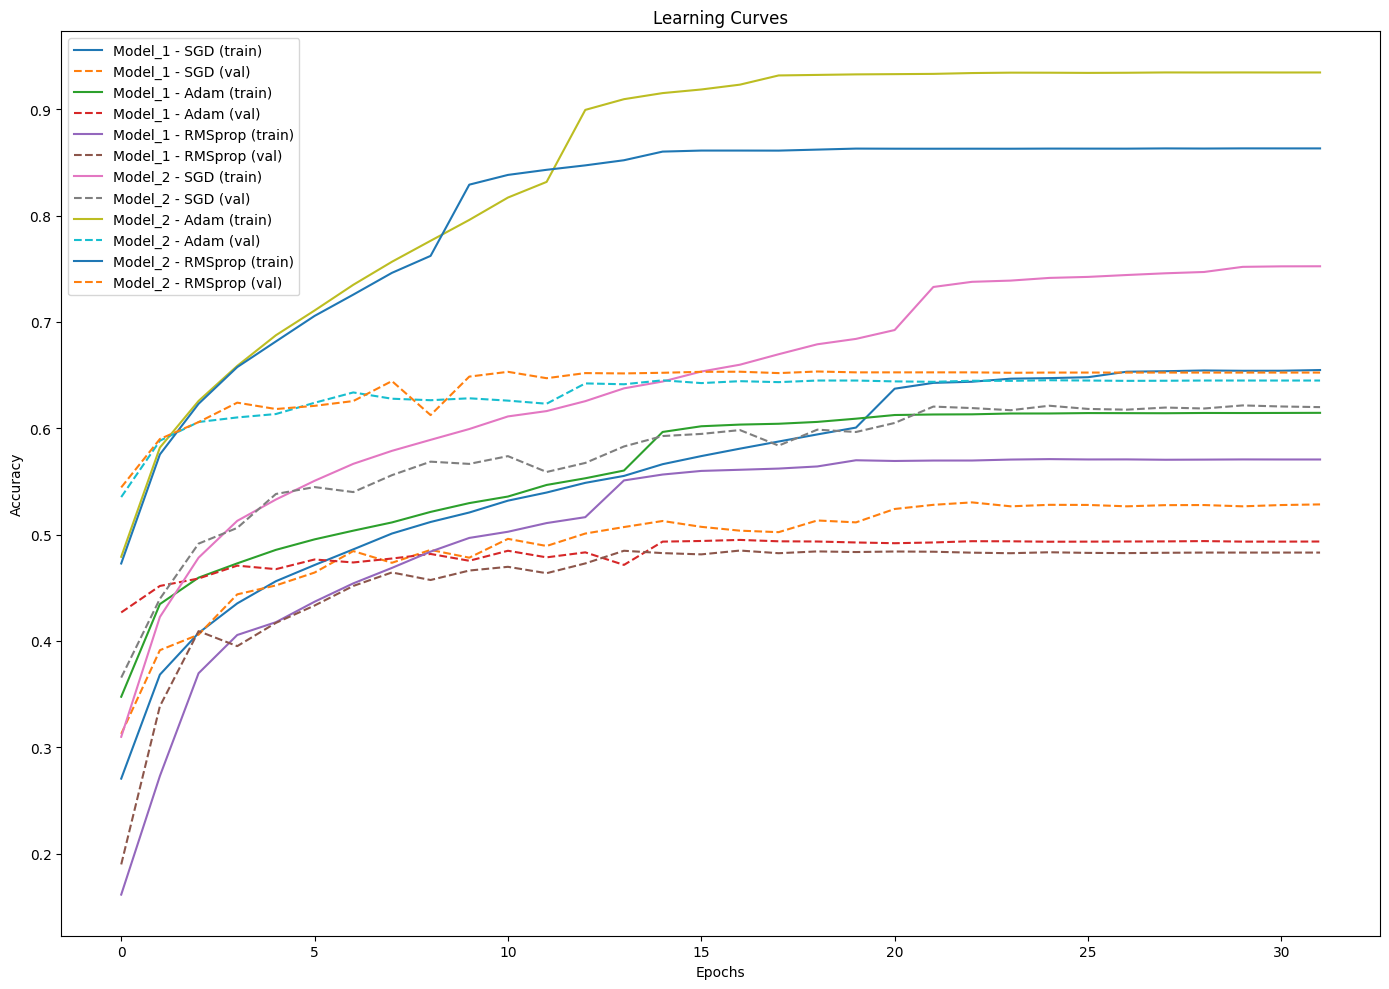

In [ ]:
evaluator.plot_learning_curves(figsize_= (14, 10))

In [ ]:
!pwd

/content


**Выводы**
1. После 15-20 эпохи по всем моделям (и оптимизаторам) достигнут предел обучения;
2. У CNN (в особенности по оптимизаторам adam, rmsprop) есть тенденция к переобучению;
3. При решении классификации изображений, CNN показывают себя гораздо лучше, чем полносвязные модели.

Прокомментируйте полученные результаты.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [ ]:
def create_model3():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape= X_train.shape[1:]),

        tf.keras.layers.Dense(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dense(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dense(10, activation= 'softmax')
    ])

def create_model4():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape= X_train.shape[1:]),

        tf.keras.layers.Conv2D(filters= 10, kernel_size= (3, 3), padding= 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),

        tf.keras.layers.MaxPooling2D(pool_size= (2, 2), padding= 'valid'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(100),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),

        tf.keras.layers.Dense(10, activation= 'softmax')
    ])

In [ ]:
models_['Model_3'] = create_model3()
models_['Model_4'] = create_model4()

Прокомментируйте полученные результаты.

In [ ]:
evaluator_bn = Evaluator(models= dict(list(models_.items())[-2:]), optimizers= optimizers_)
evaluator_bn.fit(X_train, y_train, validation_data= (X_val, y_val),
                 callbacks= callbacks_train, verbose= 1, max_epochs= 32)

  0%|          | 0/6 [00:00<?, ?it/s]

Training Model_3 with SGD optimizer
Epoch 1/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - categorical_accuracy: 0.3479 - loss: 1.8593 - val_categorical_accuracy: 0.4516 - val_loss: 1.5577 - learning_rate: 0.0100
Epoch 2/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - categorical_accuracy: 0.4732 - loss: 1.5001 - val_categorical_accuracy: 0.4515 - val_loss: 1.5402 - learning_rate: 0.0100
Epoch 3/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - categorical_accuracy: 0.4992 - loss: 1.4216 - val_categorical_accuracy: 0.4933 - val_loss: 1.4347 - learning_rate: 0.0100
Epoch 4/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - categorical_accuracy: 0.5154 - loss: 1.3713 - val_categorical_accuracy: 0.4902 - val_loss: 1.4441 - learning_rate: 0.0100
Epoch 5/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - categorical_accuracy: 0.5323 - loss: 1.3252 - val_categorical_accuracy: 0.4971 - val_loss: 1.4350 - learning_rate: 0.0100
Epoch 6/32
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - categorical_accura

{('Model_3', 'SGD'): <keras.src.callbacks.history.History at 0x7d42f03329b0>,
 ('Model_3', 'Adam'): <keras.src.callbacks.history.History at 0x7d4311ff9840>,
 ('Model_3',
  'RMSprop'): <keras.src.callbacks.history.History at 0x7d4310c61900>,
 ('Model_4', 'SGD'): <keras.src.callbacks.history.History at 0x7d42c569ab00>,
 ('Model_4', 'Adam'): <keras.src.callbacks.history.History at 0x7d42c6e8e7a0>,
 ('Model_4',
  'RMSprop'): <keras.src.callbacks.history.History at 0x7d42c688ba90>}

In [ ]:
evaluator_bn.evaluate(X_val, y_val, accuracy_score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_3_SGD is 0.5144
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_3_Adam is 0.5351
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_3_RMSprop is 0.5336
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_4_SGD is 0.6482
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_4_Adam is 0.6541
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of Model_4_RMSprop is 0.6431


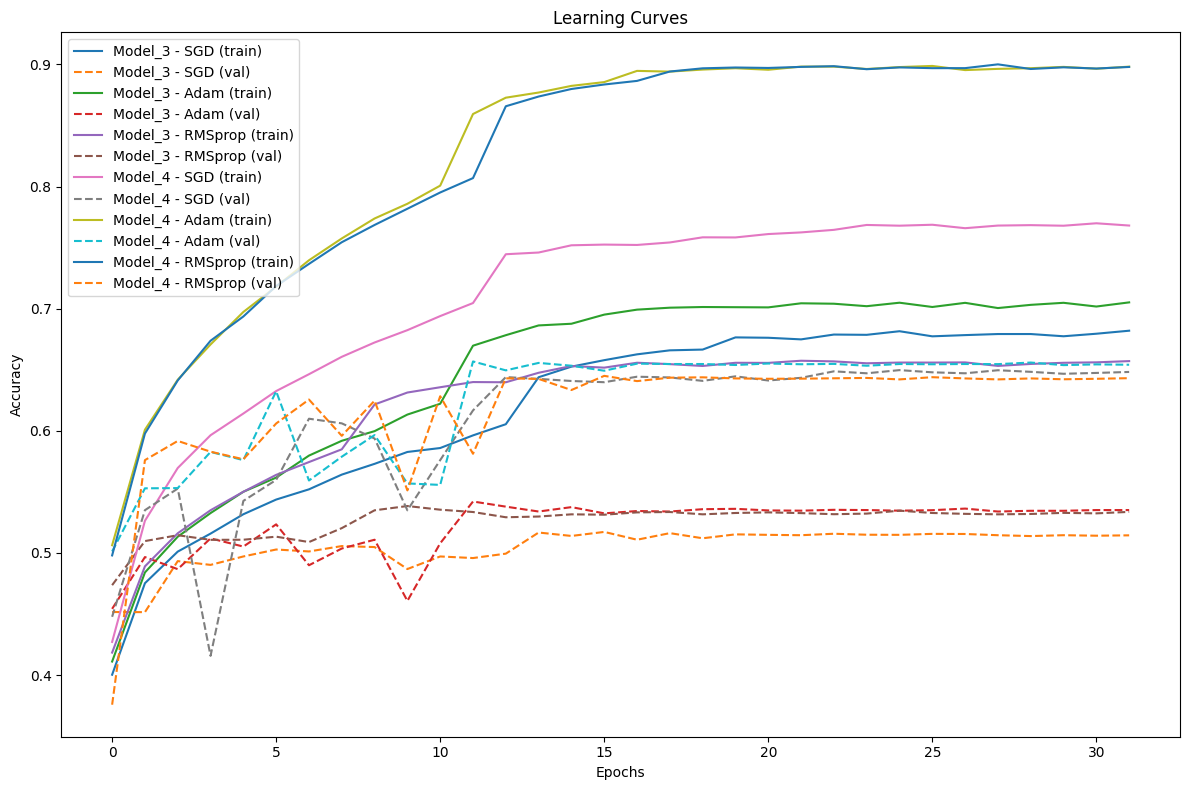

In [ ]:
evaluator_bn.plot_learning_curves()

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

**Выводы**
1. Нормализация не сильно изменила ситуацию и предельные значения по метрике accurracy на валидационной выборке остались прежними;
2. Алгоритмы rmsprop и adam в данных экспериментах оказались более склонны к переобучению в CNN на тренировочных выборках;
3. По всей видимости достигнут предел обучения данных архитектур моделей по метрике accurracy

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range= 20,
    width_shift_range= .2,
    height_shift_range= .2,
    horizontal_flip= True
)

In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

split = 30000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

In [ ]:
train_generator = datagen.flow(dg_x_train, dg_y_train, batch_size= 64)
val_generator = val_datagen.flow(dg_x_val, dg_y_val, batch_size= 64)

**Модель 1го поколения**

In [ ]:
inputs = keras.Input(shape= X_train.shape[1:], name="final_model")

# 1st conv block
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', trainable=True)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# 2nd conv block
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', trainable=True)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('leaky_relu')(x)

block_1_output = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))(x)

# 3rd conv block
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", trainable=True)(block_1_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('leaky_relu')(x)

# 4th conv block
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", trainable=True)(x)
x = tf.keras.layers.Activation('leaky_relu')(x)

block_2_output = tf.keras.layers.add([x, block_1_output])

# 5th conv block
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", trainable=True)(block_2_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('leaky_relu')(x)

x = tf.keras.layers.Dropout(0.3)(x)

# 6th conv block
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", trainable=True)(x)
x = tf.keras.layers.Activation('leaky_relu')(x)

block_3_output = tf.keras.layers.add([x, block_2_output])

# 7th conv block
x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", trainable=True)(block_3_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('leaky_relu')(x)

# global pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# full linked layer after pooling
x = tf.keras.layers.Dense(128, activation='elu', trainable=True)(x)

x = tf.keras.layers.Dropout(0.3)(x)

# final layer
outputs = tf.keras.layers.Dense(10, activation='softmax', trainable=True)(x)

final_model = keras.Model(inputs, outputs, name="final_model_resnet")

In [ ]:
final_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath= './model/model.{epoch:02d}-{val_loss:.2f}.h5.keras'),
    tf.keras.callbacks.TensorBoard(log_dir= './logs')
]

In [ ]:
final_model.summary()

Model: "final_model_resnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ final_model         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ final_model[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 10, 10,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 10, 10,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 10,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 10,    │          0 │ activation_3[0][… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 10, 10,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 10, 10,    │          0 │ batch_normalizat

 Total params: 260,170 (1016.29 KB)

 Trainable params: 259,466 (1013.54 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
tf.keras.utils.plot_model(final_model, "final_model.png", show_shapes= True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


**Обучение модели 1го поколения**

In [ ]:
## TODO
final_model.compile(
    optimizer= tf.keras.optimizers.SGD(
       learning_rate= .005,
       momentum= 1/4,
       nesterov= True
    ),
    loss= categorical_crossentropy,
    metrics= ['accuracy']
)
final_model.fit(
    X_train,
    y_train,
    batch_size= 64,
    epochs= 64,
    validation_data= (X_val, y_val),
    callbacks= final_callbacks
)

Epoch 1/64
  1/625 ━━━━━━━━━━━━━━━━━━━━ 20:19 2s/step - accuracy: 0.4844 - loss: 1.4138

E0000 00:00:1732288537.094315  298041 meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/final_model_resnet_1/activation_5_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/final_model_resnet_1/conv2d_5_1/add'.


625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 77ms/step - accuracy: 0.4227 - loss: 1.5538 - val_accuracy: 0.4665 - val_loss: 1.4723
Epoch 2/64
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.4887 - loss: 1.3897 - val_accuracy: 0.4681 - val_loss: 1.4999
Epoch 3/64
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.5324 - loss: 1.2899 - val_accuracy: 0.5360 - val_loss: 1.2732
Epoch 4/64
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - accuracy: 0.5716 - loss: 1.1874 - val_accuracy: 0.5355 - val_loss: 1.3029
Epoch 5/64
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.5926 - loss: 1.1353 - val_accuracy: 0.4860 - val_loss: 1.4394
Epoch 6/64
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.6217 - loss: 1.0627 - val_accuracy: 0.5761 - val_loss: 1.1905
Epoch 7/64
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 73ms/step - accuracy: 0.6336 - loss: 1.0237 - val_accuracy: 0.5546 - val_loss: 1.2683
Epoch 8/64
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.6547 - loss: 0.9732 - val_accurac

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
predict_x= final_model.predict(X_test)
classes_x= np.argmax(predict_x, axis= 1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step

 Test_acc = 0.6635


In [ ]:
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1000
           1       0.68      0.94      0.79      1000
           2       0.66      0.59      0.63      1000
           3       0.51      0.64      0.57      1000
           4       0.92      0.21      0.34      1000
           5       0.91      0.33      0.49      1000
           6       0.43      0.96      0.59      1000
           7       0.91      0.56      0.70      1000
           8       0.95      0.71      0.81      1000
           9       0.74      0.88      0.80      1000

    accuracy                           0.66     10000
   macro avg       0.75      0.66      0.65     10000
weighted avg       0.75      0.66      0.65     10000



**Попытка дообучить модель 1го поколения**

In [ ]:
new_final_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath= './new_model_dg/new_model_dg.{epoch:02d}-{val_loss:.2f}.h5.keras'),
    tf.keras.callbacks.TensorBoard(log_dir= './new_model_dg_logs')
]

In [ ]:
## TODO
new_final_model.compile(
    optimizer= tf.keras.optimizers.SGD(
       learning_rate= .005,
       momentum= 1/4,
       nesterov= True
    ),
    loss= categorical_crossentropy,
    metrics= ['accuracy']
)
new_final_model.fit(
    X_train,
    y_train,
    batch_size= 64,
    epochs= 32,
    validation_data= (X_val, y_val),
    callbacks= new_final_callbacks
)

Epoch 1/32


E0000 00:00:1732334218.041726  502261 meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/final_model_resnet_1/activation_5_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/final_model_resnet_1/conv2d_5_1/add'.


625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 76ms/step - accuracy: 0.8784 - loss: 0.3483 - val_accuracy: 0.6435 - val_loss: 1.2710
Epoch 2/32
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 101ms/step - accuracy: 0.8826 - loss: 0.3403 - val_accuracy: 0.7503 - val_loss: 0.7816
Epoch 3/32
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.8808 - loss: 0.3361 - val_accuracy: 0.7154 - val_loss: 0.9201
Epoch 4/32
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.8861 - loss: 0.3223 - val_accuracy: 0.6733 - val_loss: 1.2225
Epoch 5/32
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 74ms/step - accuracy: 0.8895 - loss: 0.3176 - val_accuracy: 0.6582 - val_loss: 1.2673
Epoch 6/32
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8907 - loss: 0.3112 - val_accuracy: 0.7364 - val_loss: 0.9146
Epoch 7/32
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8959 - loss: 0.3001 - val_accuracy: 0.7054 - val_loss: 1.0787
Epoch 8/32
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8948 - loss: 0.3016 - val_accu

In [ ]:
new_predict_x = new_final_model.predict(X_test)
new_classes_x = np.argmax(new_predict_x, axis= 1)

print(classification_report(y_test, new_classes_x))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      1000
           1       0.99      0.62      0.76      1000
           2       0.72      0.68      0.70      1000
           3       0.43      0.88      0.58      1000
           4       0.74      0.81      0.77      1000
           5       0.95      0.29      0.45      1000
           6       0.95      0.59      0.73      1000
           7       0.90      0.76      0.82      1000
           8       0.82      0.87      0.84      1000
           9       0.76      0.89      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.80      0.73      0.73     10000
weighted avg       0.80      0.73      0.73     10000



**Обучение модели 1го поколения с использованием аугментации**

In [ ]:
## TODO
new_final_model_1.compile(
    optimizer= tf.keras.optimizers.SGD(
       learning_rate= .01,
       momentum= 1/2,
       nesterov= True
    ),
    loss= categorical_crossentropy,
    metrics= ['accuracy']
)
new_final_model_1.fit(
    train_generator,
    batch_size= 64,
    epochs= 64,
    validation_data= val_generator,
    callbacks= new_final_callbacks
)

Epoch 1/64


/home/akozlov/Documents/work/Python_scripts/photo_classifier_cifar10_ipynb/cnn_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.6849 - loss: 0.9603 - val_accuracy: 0.6957 - val_loss: 0.9133
Epoch 2/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.7155 - loss: 0.8301 - val_accuracy: 0.7692 - val_loss: 0.6971
Epoch 3/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.7224 - loss: 0.8077 - val_accuracy: 0.7663 - val_loss: 0.6671
Epoch 4/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.7216 - loss: 0.7992 - val_accuracy: 0.7940 - val_loss: 0.5841
Epoch 5/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.7318 - loss: 0.7822 - val_accuracy: 0.6562 - val_loss: 1.1449
Epoch 6/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.7358 - loss: 0.7733 - val_accuracy: 0.6974 - val_loss: 0.9552
Epoch 7/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.7314 - loss: 0.7699 - val_accuracy: 0.7209 - val_loss: 0.8752
Epoch 8/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.7344 - loss: 0.7746 - val_accurac

А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

In [ ]:
new_predict_x_dg = new_final_model_1.predict(X_test)
new_classes_x_dg = np.argmax(new_predict_x_dg, axis= 1)

print(classification_report(y_test, new_classes_x_dg))

test_acc = accuracy_score(y_test, new_classes_x_dg)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           0       0.86      0.60      0.71      1000
           1       0.89      0.85      0.87      1000
           2       0.96      0.41      0.57      1000
           3       0.69      0.58      0.63      1000
           4       0.60      0.86      0.71      1000
           5       0.75      0.71      0.73      1000
           6       0.76      0.86      0.80      1000
           7       0.90      0.69      0.78      1000
           8       0.55      0.98      0.70      1000
           9       0.85      0.86      0.86      1000

    accuracy                           0.74     10000
   macro avg       0.78      0.74      0.74     10000
weighted avg       0.78      0.74      0.74     10000


 Test_acc = 0.74


**Изменены параметры оптимизатора и следующая попытка обучения модели 1го поколения**

In [ ]:
new_final_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath= './new_model_dg/new_model_dg.{epoch:02d}-{val_loss:.2f}.h5.keras'),
    tf.keras.callbacks.TensorBoard(log_dir= './new_model_dg_logs')
]

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range= 20,
    width_shift_range= .2,
    height_shift_range= .2,
    horizontal_flip= True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

split = 30000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

train_generator = datagen.flow(dg_x_train, dg_y_train, batch_size= 128)
val_generator = val_datagen.flow(dg_x_val, dg_y_val, batch_size= 128)

In [ ]:
## TODO
new_final_model_1.compile(
    optimizer= tf.keras.optimizers.SGD(
       learning_rate= .005,
       momentum= 1/3,
       nesterov= True
    ),
    loss= categorical_crossentropy,
    metrics= ['accuracy']
)
new_final_model_1.fit(
    train_generator,
    batch_size= 128,
    epochs= 64,
    validation_data= val_generator,
    callbacks= new_final_callbacks
)

Epoch 1/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.7948 - loss: 0.5887 - val_accuracy: 0.7303 - val_loss: 0.8854
Epoch 2/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.7974 - loss: 0.5885 - val_accuracy: 0.7665 - val_loss: 0.7233
Epoch 3/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.7974 - loss: 0.5782 - val_accuracy: 0.7721 - val_loss: 0.7101
Epoch 4/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.7996 - loss: 0.5787 - val_accuracy: 0.7833 - val_loss: 0.6382
Epoch 5/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.7969 - loss: 0.5862 - val_accuracy: 0.7019 - val_loss: 1.0713
Epoch 6/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.8012 - loss: 0.5742 - val_accuracy: 0.7168 - val_loss: 0.9668
Epoch 7/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.7994 - loss: 0.5756 - val_accuracy: 0.7946 - val_loss: 0.6072
Epoch 8/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.8017 - loss: 0.5766 - 

In [ ]:
new_predict_x_dg = new_final_model_1.predict(X_test)
new_classes_x_dg = np.argmax(new_predict_x_dg, axis= 1)

print(classification_report(y_test, new_classes_x_dg))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           0       0.78      0.88      0.82      1000
           1       0.94      0.84      0.89      1000
           2       0.58      0.83      0.68      1000
           3       0.76      0.55      0.64      1000
           4       0.91      0.54      0.68      1000
           5       0.82      0.68      0.75      1000
           6       0.72      0.92      0.81      1000
           7       0.86      0.84      0.85      1000
           8       0.88      0.90      0.89      1000
           9       0.81      0.94      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.79     10000
weighted avg       0.81      0.79      0.79     10000



**Модель 2го поколения**

In [ ]:
inputs = keras.Input(shape= dg_x_train.shape[1:], name= "new_final_model_dg_1")

# 1st conv block
x = keras.layers.Conv2D(32, (2, 2), padding= "same", trainable=True)(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

# 2nd conv block
x = keras.layers.Conv2D(64, (3, 3), padding= "same", trainable=True)(x)
x = keras.layers.Activation('relu')(x)

# 3nd conv block
x = keras.layers.Conv2D(128, (3, 3), padding= "same", trainable=True)(x)
x = keras.layers.Activation('relu')(x)

# 4th conv block
x = keras.layers.Conv2D(128, (5, 5), padding= "same", trainable=True)(x)
x = keras.layers.Activation('relu')(x)

block_1_output = keras.layers.MaxPooling2D(4)(x)

# 5th conv block
x = keras.layers.Conv2D(128, (5, 5), padding= "same", trainable=True)(block_1_output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('leaky_relu')(x)

# 6th conv block
x = keras.layers.Conv2D(128, (5, 5), padding= "same", trainable=True)(x)
x = keras.layers.Activation('relu')(x)

block_2_output = keras.layers.add([x, block_1_output])

# 7th conv block
x = keras.layers.Conv2D(128, (5, 5), padding="same", trainable=True)(block_2_output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('leaky_relu')(x)

block_3_output = keras.layers.add([x, block_2_output])

# 8th conv block
x = keras.layers.Conv2D(256, (5, 5), padding="same", trainable=True)(block_3_output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('leaky_relu')(x)

# global pooling
x = keras.layers.GlobalAveragePooling2D()(x)

# 1st full linked layer after pooling
x = keras.layers.Dense(1024, trainable=True)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Dropout(1/3)(x)

# final layer
outputs = keras.layers.Dense(10, activation='softmax', trainable=True)(x)

new_final_model_gd_1 = keras.Model(inputs, outputs, name="final_model_resnet_gd_1")

In [ ]:
new_final_model_gd_1.summary()

Model: "final_model_resnet_gd_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ new_final_model_dg… │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_164 (Conv2D) │ (None, 32, 32,    │        416 │ new_final_model_… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_164[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_165 (Conv2D) │ (None, 32, 32,    │     18,496 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 32, 32,    │          0 │ conv2d_165[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_166 (Conv2D) │ (None, 32, 32,    │     73,856 │ activation_190[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 32, 32,    │          0 │ conv2d_166[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_167 (Conv2D) │ (None, 32, 32,    │    409,728 │ activation_191[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 32, 32,    │          0 │ conv2d_167[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 8, 8, 128) │          0 │ activation_192[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_168 (Conv2D) │ (None, 8, 8, 128) │    409,728 │ max_pooling2d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_168[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_193      │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_169 (Conv2D) │ (None, 8, 8, 128) │    409,728 │ activation_193[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_194      │ (None, 8, 8, 128) │          0 │ conv2d_169[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 8, 8, 128) │          0 │ activation_194[0… │
│                     │                   │            │ max_pooling2d_22… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,826,730 (10.78 MB)

 Trainable params: 2,825,642 (10.78 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range= 30,
    width_shift_range= .25,
    height_shift_range= .25,
    horizontal_flip= True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

split = 30000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

train_generator = datagen.flow(dg_x_train, dg_y_train, batch_size= 64)
val_generator = val_datagen.flow(dg_x_val, dg_y_val, batch_size= 64)

**Обучение модели 2го поколения с использованием аугментации**

In [ ]:
## TODO
new_final_model_gd_1.compile(
    optimizer= tf.keras.optimizers.SGD(
       learning_rate= .01,
       momentum= 1/3,
       nesterov= True
    ),
    loss= categorical_crossentropy,
    metrics= ['accuracy']
)
new_final_model_gd_1.fit(
    train_generator,
    batch_size= 64,
    epochs= 98,
    validation_data= val_generator,
    callbacks= new_final_callbacks
)

Epoch 1/98
469/469 ━━━━━━━━━━━━━━━━━━━━ 179s 378ms/step - accuracy: 0.3138 - loss: 1.8525 - val_accuracy: 0.3134 - val_loss: 1.9320
Epoch 2/98
469/469 ━━━━━━━━━━━━━━━━━━━━ 181s 385ms/step - accuracy: 0.4736 - loss: 1.4372 - val_accuracy: 0.4473 - val_loss: 1.7672
Epoch 3/98
469/469 ━━━━━━━━━━━━━━━━━━━━ 174s 371ms/step - accuracy: 0.5354 - loss: 1.2886 - val_accuracy: 0.2740 - val_loss: 3.4145
Epoch 4/98
469/469 ━━━━━━━━━━━━━━━━━━━━ 179s 382ms/step - accuracy: 0.5778 - loss: 1.1900 - val_accuracy: 0.6089 - val_loss: 1.1148
Epoch 5/98
469/469 ━━━━━━━━━━━━━━━━━━━━ 176s 375ms/step - accuracy: 0.6142 - loss: 1.0973 - val_accuracy: 0.5610 - val_loss: 1.4285
Epoch 6/98
469/469 ━━━━━━━━━━━━━━━━━━━━ 177s 378ms/step - accuracy: 0.6383 - loss: 1.0226 - val_accuracy: 0.6219 - val_loss: 1.1069
Epoch 7/98
469/469 ━━━━━━━━━━━━━━━━━━━━ 210s 395ms/step - accuracy: 0.6571 - loss: 0.9731 - val_accuracy: 0.6271 - val_loss: 1.1065
Epoch 8/98
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 384ms/step - accuracy: 0.6746 -

In [ ]:
new_predict_x_gd_1 = new_final_model_gd_1.predict(X_test)
new_classes_x_gd_1 = np.argmax(new_predict_x_gd_1, axis= 1)

test_acc = accuracy_score(y_test, new_classes_x_gd_1)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 86ms/step

 Test_acc = 0.8528
Это победа!


**Выводы**
1. В отличие от тренировочных моделей нейросетей, final_model более сбалансированно обучалась => на тестовой (X_val) выборке наблюдалась меньшая разница с обучаемой (X_train);
2. При настройке параметров оптимизатора (в отличе от настроек по умолчанию) наблюдалось улучшение сходимости функции потерь уже на ранних этапах обучения => настройка и выбор оптимизатора - одна из первостепенных вещей при создании модели;
3. Предположу, что при аугментации данных точность может еще сильнее повысится (этот вывод был написан до того, как я исспользовал аугментацию, так что да, точность еще сильнее повысилась);
4. Прототип модели взят отсюда (https://keras.io/guides/functional_api/#a-toy-resnet-model), но моя модель имеет более чем в 10 раз больше обучаемых параметров (~ 2.9M), чем та, что указана в источнике (~220K) и за счет этого accurracy увеличилась более чем на 5 % по сравнению с прототипом